<a href="https://colab.research.google.com/github/misanchz98/bitcoin-direction-prediction/blob/main/03_modeling/03_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Modelos de Deep Learning para Series Temporales con Walk-Forward Validation

En este notebook implementamos diferentes modelos de **Deep Learning** y técnicas de validación temporal con **Purged Walk-Forward Split**.  

Incluye:
- Preprocesamiento y creación de secuencias.
- Modelos: LSTM, GRU, CNN-LSTM, Transformer y TCN.
- Métricas personalizadas y evaluación.
- Importancia de características.
- Pipeline de entrenamiento y validación.

## 🔹 1. Librerías
Instalamos e importamos las librerías necesarias para manipulación de datos, visualización, machine learning y deep learning.


In [125]:
#!pip install boruta
#!pip install keras-tcn --quiet

In [126]:
# =============================================================================
# LIBRERIAS
# =============================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef)

from sklearn.model_selection import BaseCrossValidator
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, LSTM, GRU, Conv1D, MaxPooling1D,
                                     Flatten, Input, LayerNormalization)
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.callbacks import Callback
import warnings

# Establecer el nivel de advertencias a "ignore" para ignorar todas las advertencias
warnings.filterwarnings("ignore")

## 🔹 2. Semillas
Para garantizar **reproducibilidad** en los experimentos, es importante fijar las semillas de las librerías que generan números aleatorios:

- `os.environ['PYTHONHASHSEED']` → controla el hash en Python.  
- `numpy.random.seed` → asegura resultados reproducibles en operaciones de NumPy.  
- `random.seed` → fija la semilla del generador de números aleatorios nativo de Python.  
- `tf.random.set_seed` → fija la semilla para TensorFlow y Keras.  

Esto ayuda a que los modelos se entrenen con resultados consistentes entre ejecuciones.

In [127]:
# resetting the seeds for reproducibility
def reset_random_seeds():
    n = 42
    os.environ['PYTHONHASHSEED'] = str(n)
    tf.random.set_seed(n)
    np.random.seed(n)
    random.seed(n)

reset_random_seeds()

## 🔹 3. Conjunto de Datos
Importamos el conjunto de datos en nuestro entorno de trabajo. Se encuentran almacenados en un archivo CSV llamado `btc_historical_data_eda.csv`, cuya obtención se explica en el *notebook* `02_data_analysis.ipynb`.

In [128]:
# Importamos CSV
url = 'https://raw.githubusercontent.com/misanchz98/bitcoin-direction-prediction/main/02_data_analysis/data/btc_historical_data_eda.csv'
df_bitcoin = pd.read_csv(url, parse_dates=['Open time'])
df_bitcoin

,Open time,Close,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Range,Candle,Target,CMF_20,MFI_14,...,c2_ta_tendencia,c3_ta_tendencia,c1_ta_momentum,c2_ta_momentum,c3_ta_momentum,c4_ta_momentum,c5_ta_momentum,c1_ta_volatilidad,c2_ta_volatilidad,c3_ta_volatilidad
0,2017-10-05,4292.43,9158.0,351.042019,1.483037e+06,245.00,83.84,1,0.081329,56.225018,...,1.426309,-0.136861,1.317719,-0.126726,-1.676720,1.289633,0.019128,-4.644643,-0.938175,-0.259897
1,2017-10-06,4369.00,6546.0,226.148177,9.881066e+05,125.00,50.01,1,0.090972,62.048701,...,1.684975,-0.223654,1.843789,-0.313902,-0.766032,1.200655,0.108543,-4.656021,-1.404483,-0.298095
2,2017-10-07,4423.00,4804.0,145.313076,6.371469e+05,166.94,54.00,1,0.072898,60.780168,...,1.837639,-0.272101,1.714315,0.851111,-1.474281,-0.169404,-0.611932,-4.658149,-1.694457,-0.310605
3,2017-10-08,4640.00,7580.0,280.094854,1.268661e+06,233.00,215.00,1,0.064115,66.225272,...,2.655718,-0.595153,4.539268,-1.327677,-1.397994,0.344940,0.095779,-4.643444,-2.930102,-0.299058
4,2017-10-09,4786.95,10372.0,350.756559,1.654275e+06,339.98,146.95,0,0.105281,66.423592,...,3.068594,-0.711866,4.065484,0.284535,-0.496135,-0.373562,-0.383308,-4.619178,-3.116037,-0.259659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,2025-08-16,117380.66,1179842.0,2995.228650,3.521588e+08,755.01,38.62,1,-0.078079,61.679789,...,-2.974279,-0.597347,-1.738575,-0.246759,0.045690,1.947962,-0.826190,11.130802,0.715864,-3.617415
2873,2025-08-17,117405.01,1177563.0,2804.731130,3.307994e+08,1402.79,24.35,0,-0.071478,61.441782,...,-3.056170,-0.520901,-2.679964,0.452454,-1.078307,1.833305,-0.382838,11.062656,0.708259,-3.717682
2874,2025-08-18,116227.05,3345487.0,7647.218200,8.850528e+08,2903.61,-1177.96,0,-0.058026,54.527915,...,-3.371373,-0.335897,-3.708156,1.216496,-0.767095,1.913662,1.633951,11.085307,1.427748,-3.651715
2875,2025-08-19,112872.94,3291170.0,8609.360780,9.840874e+08,3993.11,-3354.11,1,-0.133646,53.037041,...,-4.158761,0.112011,-5.328226,0.713262,0.105456,1.232647,-1.954862,11.229262,3.161925,-3.269720


## 🔹 4. Split Purgado Walk-Forward

Definimos un validador temporal con **embargo** para evitar fugas de información y simular un escenario *walk-forward*.

### 📘 Purged Time Series Split

La técnica **Purged Time Series Split** se utiliza para realizar validación cruzada en series temporales, evitando fugas de información entre entrenamiento y validación.

#### 🧠 ¿Por qué es necesaria?

En series temporales (como datos financieros), los datos futuros **no deben influir** en el entrenamiento del modelo. Usar validación cruzada tradicional puede provocar que el modelo aprenda de datos que cronológicamente ocurren después de los datos de validación, lo que genera resultados engañosos.

#### 🔍 ¿Qué significa "purged"?

Se eliminan (purge) los datos cercanos al conjunto de validación del conjunto de entrenamiento para evitar que el modelo aprenda patrones que están demasiado próximos en el tiempo y puedan estar correlacionados.

#### ⏳ ¿Qué es el "embargo"?

Es una zona de exclusión temporal entre el final del conjunto de entrenamiento y el inicio del conjunto de validación. Sirve para evitar que eventos cercanos contaminen el entrenamiento.

|--- entrenamiento ---| embargo |--- validación ---|

#### ✅ Ventajas

- Evita **data leakage** (fugas de información).
- Simula condiciones reales de predicción.
- Mejora la **validez del modelo** en contextos temporales como mercados financieros.

Esta técnica es especialmente útil cuando se trabaja con datos como precios de Bitcoin, donde el orden temporal y la independencia entre conjuntos es crítica.

In [129]:
# =======================================
# SPLIT PURGADO WALK-FORWARD
# =======================================

import itertools as itt
import numbers
import numpy as np
import pandas as pd

from abc import abstractmethod
from typing import Iterable, Tuple, List


import itertools as itt
import numbers
import numpy as np
import pandas as pd

from abc import abstractmethod
from typing import Iterable, Tuple, List


class BaseTimeSeriesCrossValidator:
    """
    Abstract class for time series cross-validation.

    Time series cross-validation requires each sample has a prediction time pred_time, at which the features are used to
    predict the response, and an evaluation time eval_time, at which the response is known and the error can be
    computed. Importantly, it means that unlike in standard sklearn cross-validation, the samples X, response y,
    pred_times and eval_times must all be pandas dataframe/series having the same index. It is also assumed that the
    samples are time-ordered with respect to the prediction time (i.e. pred_times is non-decreasing).

    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.

    """
    def __init__(self, n_splits=10):
        if not isinstance(n_splits, numbers.Integral):
            raise ValueError(f"The number of folds must be of Integral type. {n_splits} of type {type(n_splits)}"
                             f" was passed.")
        n_splits = int(n_splits)
        if n_splits <= 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting n_splits = 2 "
                             f"or more, got n_splits = {n_splits}.")
        self.n_splits = n_splits
        self.pred_times = None
        self.eval_times = None
        self.indices = None

    @abstractmethod
    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, pd.Series):
            raise ValueError('X should be a pandas DataFrame/Series.')
        if not isinstance(y, pd.Series) and y is not None:
            raise ValueError('y should be a pandas Series.')
        if not isinstance(pred_times, pd.Series):
            raise ValueError('pred_times should be a pandas Series.')
        if not isinstance(eval_times, pd.Series):
            raise ValueError('eval_times should be a pandas Series.')
        if y is not None and (X.index == y.index).sum() != len(y):
            raise ValueError('X and y must have the same index')
        if (X.index == pred_times.index).sum() != len(pred_times):
            raise ValueError('X and pred_times must have the same index')
        if (X.index == eval_times.index).sum() != len(eval_times):
            raise ValueError('X and eval_times must have the same index')

        if not pred_times.equals(pred_times.sort_values()):
            raise ValueError('pred_times should be sorted')
        if not eval_times.equals(eval_times.sort_values()):
            raise ValueError('eval_times should be sorted')

        self.pred_times = pred_times
        self.eval_times = eval_times
        self.indices = np.arange(X.shape[0])


class PurgedWalkForwardCV(BaseTimeSeriesCrossValidator):
    """
    Purged walk-forward cross-validation

    As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.

    The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
    validation round, n_test_splits contiguous folds are used as the test set, while the train set consists in between
    min_train_splits and max_train_splits immediately preceding folds.

    Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
    that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
    overlapping samples are dropped.)

    With split_by_times = True in the split method, it is also possible to split the samples in folds spanning equal
    time intervals (using the prediction time as a time tag), instead of folds containing equal numbers of samples.

    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.

    n_test_splits : int, default = 1
        Number of folds used in the test set. Must be at least 1.

    min_train_splits: int, default = 2
        Minimal number of folds to be used in the train set.

    max_train_splits: int, default = None
        Maximal number of folds to be used in the train set. If None, there is no upper limit.

    """
    def __init__(self, n_splits=10, n_test_splits=1, min_train_splits=2, max_train_splits=None):
        super().__init__(n_splits)
        if not isinstance(n_test_splits, numbers.Integral):
            raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                             f"{type(n_test_splits)} was passed.")
        n_test_splits = int(n_test_splits)
        if n_test_splits <= 0 or n_test_splits >= self.n_splits - 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
        self.n_test_splits = n_test_splits

        if not isinstance(min_train_splits, numbers.Integral):
            raise ValueError(f"The minimal number of train folds must be of Integral type. {min_train_splits} of type "
                             f"{type(min_train_splits)} was passed.")
        min_train_splits = int(min_train_splits)
        if min_train_splits <= 0 or min_train_splits >= self.n_splits - self.n_test_splits:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"min_train_splits between 1 and n_splits - n_test_splits, got min_train_splits = "
                             f"{min_train_splits}.")
        self.min_train_splits = min_train_splits

        if max_train_splits is None:
            max_train_splits = self.n_splits - self.n_test_splits
        if not isinstance(max_train_splits, numbers.Integral):
            raise ValueError(f"The maximal number of train folds must be of Integral type. {max_train_splits} of type "
                             f"{type(max_train_splits)} was passed.")
        max_train_splits = int(max_train_splits)
        if max_train_splits <= 0 or max_train_splits > self.n_splits - self.n_test_splits:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"max_train_split between 1 and n_splits - n_test_splits, got max_train_split = "
                             f"{max_train_splits}.")
        self.max_train_splits = max_train_splits
        self.fold_bounds = []

    def split(self, X: pd.DataFrame, y: pd.Series = None, pred_times: pd.Series = None, eval_times: pd.Series = None,
              split_by_time: bool = False) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        """
        Yield the indices of the train and test sets.

        Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
        not labels.

        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features), required
            Samples. Only used to extract n_samples.

        y : pd.Series, not used, inherited from _BaseKFold

        pred_times : pd.Series, shape (n_samples,), required
            Times at which predictions are made. pred_times.index has to coincide with X.index.

        eval_times : pd.Series, shape (n_samples,), required
            Times at which the response becomes available and the error can be computed. eval_times.index has to
            coincide with X.index.

        split_by_time: bool
            If False, the folds contain an (approximately) equal number of samples. If True, the folds span identical
            time intervals.

        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.

        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.

        """
        super().split(X, y, pred_times, eval_times)

        # Fold boundaries
        self.fold_bounds = compute_fold_bounds(self, split_by_time)

        count_folds = 0
        for fold_bound in self.fold_bounds:
            if count_folds < self.min_train_splits:
                count_folds = count_folds + 1
                continue
            if self.n_splits - count_folds < self.n_test_splits:
                break
            # Computes the bounds of the test set, and the corresponding indices
            test_indices = self.compute_test_set(fold_bound, count_folds)
            # Computes the train set indices
            train_indices = self.compute_train_set(fold_bound, count_folds)

            count_folds = count_folds + 1
            yield train_indices, test_indices

    def compute_train_set(self, fold_bound: int, count_folds: int) -> np.ndarray:
        """
        Compute the position indices of samples in the train set.

        Parameters
        ----------
        fold_bound : int
            Bound between the train set and the test set.

        count_folds : int
            The number (starting at 0) of the first fold in the test set.

        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.

        """
        if count_folds > self.max_train_splits:
            start_train = self.fold_bounds[count_folds - self.max_train_splits]
        else:
            start_train = 0
        train_indices = np.arange(start_train, fold_bound)
        # Purge
        train_indices = purge(self, train_indices, fold_bound, self.indices[-1])
        return train_indices

    def compute_test_set(self, fold_bound: int, count_folds: int) -> np.ndarray:
        """
        Compute the indices of the samples in the test set.

        Parameters
        ----------
        fold_bound : int
            Bound between the train set and the test set.

        count_folds : int
            The number (starting at 0) of the first fold in the test set.

        Returns
        -------
        test_indices: np.ndarray
            A numpy array containing the test indices.

        """
        if self.n_splits - count_folds > self.n_test_splits:
            end_test = self.fold_bounds[count_folds + self.n_test_splits]
        else:
            end_test = self.indices[-1] + 1
        return np.arange(fold_bound, end_test)


class CombPurgedKFoldCV(BaseTimeSeriesCrossValidator):
    """
    Purged and embargoed combinatorial cross-validation

    As described in Advances in financial machine learning, Marcos Lopez de Prado, 2018.

    The samples are decomposed into n_splits folds containing equal numbers of samples, without shuffling. In each cross
    validation round, n_test_splits folds are used as the test set, while the other folds are used as the train set.
    There are as many rounds as n_test_splits folds among the n_splits folds.

    Each sample should be tagged with a prediction time pred_time and an evaluation time eval_time. The split is such
    that the intervals [pred_times, eval_times] associated to samples in the train and test set do not overlap. (The
    overlapping samples are dropped.) In addition, an "embargo" period is defined, giving the minimal time between an
    evaluation time in the test set and a prediction time in the training set. This is to avoid, in the presence of
    temporal correlation, a contamination of the test set by the train set.

    Parameters
    ----------
    n_splits : int, default=10
        Number of folds. Must be at least 2.

    n_test_splits : int, default=2
        Number of folds used in the test set. Must be at least 1.

    embargo_td : pd.Timedelta, default=0
        Embargo period (see explanations above).

    """
    def __init__(self, n_splits=10, n_test_splits=2, embargo_td=pd.Timedelta(minutes=0)):
        super().__init__(n_splits)
        if not isinstance(n_test_splits, numbers.Integral):
            raise ValueError(f"The number of test folds must be of Integral type. {n_test_splits} of type "
                             f"{type(n_test_splits)} was passed.")
        n_test_splits = int(n_test_splits)
        if n_test_splits <= 0 or n_test_splits > self.n_splits - 1:
            raise ValueError(f"K-fold cross-validation requires at least one train/test split by setting "
                             f"n_test_splits between 1 and n_splits - 1, got n_test_splits = {n_test_splits}.")
        self.n_test_splits = n_test_splits
        if not isinstance(embargo_td, pd.Timedelta):
            raise ValueError(f"The embargo time should be of type Pandas Timedelta. {embargo_td} of type "
                             f"{type(embargo_td)} was passed.")
        if embargo_td < pd.Timedelta(minutes=0):
            raise ValueError(f"The embargo time should be positive, got embargo = {embargo_td}.")
        self.embargo_td = embargo_td

    def split(self, X: pd.DataFrame, y: pd.Series = None,
              pred_times: pd.Series = None, eval_times: pd.Series = None) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        """
        Yield the indices of the train and test sets.

        Although the samples are passed in the form of a pandas dataframe, the indices returned are position indices,
        not labels.

        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features), required
            Samples. Only used to extract n_samples.

        y : pd.Series, not used, inherited from _BaseKFold

        pred_times : pd.Series, shape (n_samples,), required
            Times at which predictions are made. pred_times.index has to coincide with X.index.

        eval_times : pd.Series, shape (n_samples,), required
            Times at which the response becomes available and the error can be computed. eval_times.index has to
            coincide with X.index.

        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.

        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.

        """
        super().split(X, y, pred_times, eval_times)

        # Fold boundaries
        fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(self.indices, self.n_splits)]
        # List of all combinations of n_test_splits folds selected to become test sets
        selected_fold_bounds = list(itt.combinations(fold_bounds, self.n_test_splits))
        # In order for the first round to have its whole test set at the end of the dataset
        selected_fold_bounds.reverse()

        for fold_bound_list in selected_fold_bounds:
            # Computes the bounds of the test set, and the corresponding indices
            test_fold_bounds, test_indices = self.compute_test_set(fold_bound_list)
            # Computes the train set indices
            train_indices = self.compute_train_set(test_fold_bounds, test_indices)

            yield train_indices, test_indices

    def compute_train_set(self, test_fold_bounds: List[Tuple[int, int]], test_indices: np.ndarray) -> np.ndarray:
        """
        Compute the position indices of samples in the train set.

        Parameters
        ----------
        test_fold_bounds : List of tuples of position indices
            Each tuple records the bounds of a block of indices in the test set.

        test_indices : np.ndarray
            A numpy array containing all the indices in the test set.

        Returns
        -------
        train_indices: np.ndarray
            A numpy array containing all the indices in the train set.

        """
        # As a first approximation, the train set is the complement of the test set
        train_indices = np.setdiff1d(self.indices, test_indices)
        # But we now have to purge and embargo
        for test_fold_start, test_fold_end in test_fold_bounds:
            # Purge
            train_indices = purge(self, train_indices, test_fold_start, test_fold_end)
            # Embargo
            train_indices = embargo(self, train_indices, test_indices, test_fold_end)
        return train_indices

    def compute_test_set(self, fold_bound_list: List[Tuple[int, int]]) -> Tuple[List[Tuple[int, int]], np.ndarray]:
        """
        Compute the indices of the samples in the test set.

        Parameters
        ----------
        fold_bound_list: List of tuples of position indices
            Each tuple records the bounds of the folds belonging to the test set.

        Returns
        -------
        test_fold_bounds: List of tuples of position indices
            Like fold_bound_list, but with the neighboring folds in the test set merged.

        test_indices: np.ndarray
            A numpy array containing the test indices.

        """
        test_indices = np.empty(0)
        test_fold_bounds = []
        for fold_start, fold_end in fold_bound_list:
            # Records the boundaries of the current test split
            if not test_fold_bounds or fold_start != test_fold_bounds[-1][-1]:
                test_fold_bounds.append((fold_start, fold_end))
            # If the current test split is contiguous to the previous one, simply updates the endpoint
            elif fold_start == test_fold_bounds[-1][-1]:
                test_fold_bounds[-1] = (test_fold_bounds[-1][0], fold_end)
            test_indices = np.union1d(test_indices, self.indices[fold_start:fold_end]).astype(int)
        return test_fold_bounds, test_indices


def compute_fold_bounds(cv: BaseTimeSeriesCrossValidator, split_by_time: bool) -> List[int]:
    """
    Compute a list containing the fold (left) boundaries.

    Parameters
    ----------
    cv: BaseTimeSeriesCrossValidator
        Cross-validation object for which the bounds need to be computed.
    split_by_time: bool
        If False, the folds contain an (approximately) equal number of samples. If True, the folds span identical
        time intervals.
    """
    if split_by_time:
        full_time_span = cv.pred_times.max() - cv.pred_times.min()
        fold_time_span = full_time_span / cv.n_splits
        fold_bounds_times = [cv.pred_times.iloc[0] + fold_time_span * n for n in range(cv.n_splits)]
        return cv.pred_times.searchsorted(fold_bounds_times)
    else:
        return [fold[0] for fold in np.array_split(cv.indices, cv.n_splits)]


def embargo(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
            test_indices: np.ndarray, test_fold_end: int) -> np.ndarray:
    """
    Apply the embargo procedure to part of the train set.

    This amounts to dropping the train set samples whose prediction time occurs within self.embargo_dt of the test
    set sample evaluation times. This method applies the embargo only to the part of the training set immediately
    following the end of the test set determined by test_fold_end.

    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times, cv.embargo_dt and cv.indices.

    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.

    test_indices : np.ndarray
        A numpy array containing all the indices of the samples in the test set.

    test_fold_end : int
        Index corresponding to the end of a test set block.

    Returns
    -------
    train_indices: np.ndarray
        The same array, with the indices subject to embargo removed.

    """
    if not hasattr(cv, 'embargo_td'):
        raise ValueError("The passed cross-validation object should have a member cv.embargo_td defining the embargo"
                         "time.")
    last_test_eval_time = cv.eval_times.iloc[test_indices[test_indices <= test_fold_end]].max()
    min_train_index = len(cv.pred_times[cv.pred_times <= last_test_eval_time + cv.embargo_td])
    if min_train_index < cv.indices.shape[0]:
        allowed_indices = np.concatenate((cv.indices[:test_fold_end], cv.indices[min_train_index:]))
        train_indices = np.intersect1d(train_indices, allowed_indices)
    return train_indices


def purge(cv: BaseTimeSeriesCrossValidator, train_indices: np.ndarray,
          test_fold_start: int, test_fold_end: int) -> np.ndarray:
    """
    Purge part of the train set.

    Given a left boundary index test_fold_start of the test set, this method removes from the train set all the
    samples whose evaluation time is posterior to the prediction time of the first test sample after the boundary.

    Parameters
    ----------
    cv: Cross-validation class
        Needs to have the attributes cv.pred_times, cv.eval_times and cv.indices.

    train_indices: np.ndarray
        A numpy array containing all the indices of the samples currently included in the train set.

    test_fold_start : int
        Index corresponding to the start of a test set block.

    test_fold_end : int
        Index corresponding to the end of the same test set block.

    Returns
    -------
    train_indices: np.ndarray
        A numpy array containing the train indices purged at test_fold_start.

    """
    time_test_fold_start = cv.pred_times.iloc[test_fold_start]
    # The train indices before the start of the test fold, purged.
    train_indices_1 = np.intersect1d(train_indices, cv.indices[cv.eval_times < time_test_fold_start])
    # The train indices after the end of the test fold.
    train_indices_2 = np.intersect1d(train_indices, cv.indices[test_fold_end:])
    return np.concatenate((train_indices_1, train_indices_2))

#class PurgedTimeSeriesSplit(BaseCrossValidator):
#    def __init__(self, n_splits=4, embargo=0, test_size=0.2):
#        self.n_splits = n_splits
#        self.embargo = embargo
#        self.test_size = test_size
#
#    def split(self, X, y=None, groups=None):
#        n_samples = len(X)
#        test_size = int(n_samples * self.test_size)
#        n_trainval = n_samples - test_size
#        fold_sizes = np.linspace(0.5, 1.0, self.n_splits+1)
#
#        for i in range(self.n_splits):
#            end = int(fold_sizes[i+1] * n_trainval)
#            val_size = int(0.15 * end)
#            val_start = end - val_size
#            val_end = end
#            train_end = max(0, val_start - self.embargo)
#            train_idx = np.arange(0, train_end)
#            val_idx = np.arange(val_start, val_end)
#
#            yield train_idx, val_idx
#
#    def get_n_splits(self, X=None, y=None, groups=None):
#        return self.n_splits

#class PurgedCV:
#    def __init__(self, embargo_size=0):
#        self.embargo_size = embargo_size
#
#    def split(self, X, events):
#        """
#        Generate purged and embargoed cross-validation splits.
#        - X: array de secuencias (no se usa directamente aquí, pero se mantiene por compatibilidad)
#        - events: Series con índice de fechas y labels (ej. Target)
#        """
#        events = events.sort_index()
#        unique_dates = events.index.unique()
#        n_splits = len(unique_dates)
#
#        for test_date in unique_dates:
#            # Test = todos los eventos en esa fecha
#            test_indices = events.index == test_date
#
#            # Train = todo lo demás, menos embargo
#            train_indices = self._get_train_indices(events, test_date, self.embargo_size)
#            yield train_indices, test_indices
#

#    def _get_train_indices(events, test_date, embargo_size):
#        train_indices = events.index != test_date
#        if embargo_size > 0:
#            embargo_dates = pd.date_range(
#                start=test_date,
#                periods=embargo_size + 1,
#                freq=events.index.freq  # necesita DateTimeIndex con freq definida
#            )
#            train_indices &= ~events.index.isin(embargo_dates)
#        return train_indices

In [130]:
class SharpeCallback(Callback):
    def __init__(self, X_val, y_val, returns_val, threshold=0.5, verbose=1):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.returns_val = returns_val
        self.threshold = threshold
        self.verbose = verbose
        self.best_sharpe = -np.inf
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(self.X_val) > self.threshold).astype(int)
        strat_returns = np.where(y_pred.flatten() == 1, self.returns_val, 0)  # solo largos
        sharpe = strat_returns.mean() / (strat_returns.std() + 1e-8) * np.sqrt(252)  # anualizado aproximado
        logs["sharpe"] = sharpe
        if self.verbose > 0:
            print(f" - val_sharpe: {sharpe:.4f}")
        if sharpe > self.best_sharpe:
            self.best_sharpe = sharpe
            self.best_weights = self.model.get_weights()


## 🔹 4. Métrica F1 Personalizada
Definimos una métrica de **F1-score** compatible con TensorFlow/Keras.

In [131]:
# =======================================
# MÉTRICA F1 PERSONALIZADA
# ======================================

def f1_score_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(tf.cast(y_pred, tf.float32))
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

## 🔹 5. Creación de Secuencias

Función para crear ventanas deslizantes en series temporales multivariadas.

In [132]:
# =======================================
# CREACIÓN DE SECUENCIAS
# =======================================

def create_windows_multivariate_np(data, target, window_size, horizon=1, shuffle=False):
    if isinstance(data, pd.DataFrame):
        data = data.values
    if isinstance(target, (pd.DataFrame, pd.Series)):
        target = target.values

    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size, :])
        y.append(target[i+window_size+horizon-1])

    X, y = np.array(X), np.array(y)

    if shuffle:
        idx = np.arange(X.shape[0])
        np.random.shuffle(idx)
        X, y = X[idx], y[idx]

    return X, y

## 🔹 5. Ajuste de hiperparámetros

In [ ]:
# --- Random Search completo ---
def run_pipeline_random_search(df, n_iter=5, **kwargs):
    param_grid = {
        "learning_rate": [0.0001, 0.0005, 0.001, 0.005],
        "batch_size": [16, 32, 64],
        "epochs": [20, 50, 100],
        "dropout": [0.1, 0.2, 0.3],
        "lstm_units": [32, 64, 128],
        "cnn_filters": [16, 32, 64],
        "kernel_size": [2, 3, 5]
    }
    hyperparam_combinations = random_search(param_grid, n_iter=n_iter)

    best_sharpe = -np.inf
    best_results = None
    best_summary = None

    for params in hyperparam_combinations:
        print(f"\nEvaluando combinación: {params}")

        models = {
            "LSTM": lambda input_shape: build_lstm(input_shape, dropout=params["dropout"], lstm_units=params["lstm_units"], learning_rate=params["learning_rate"]),
            "GRU": lambda input_shape: build_gru(input_shape, dropout=params["dropout"], lstm_units=params["lstm_units"], learning_rate=params["learning_rate"]),
            "LSTM+CNN": lambda input_shape: build_lstm_cnn(input_shape, dropout=params["dropout"], lstm_units=params["lstm_units"], cnn_filters=params["cnn_filters"], kernel_size=params["kernel_size"], learning_rate=params["learning_rate"]),
            "GRU+CNN": lambda input_shape: build_gru_cnn(input_shape, dropout=params["dropout"], lstm_units=params["lstm_units"], cnn_filters=params["cnn_filters"], kernel_size=params["kernel_size"], learning_rate=params["learning_rate"])
        }

        results_df, summary, all_preds, all_probs, all_trues = run_pipeline_walkforward(df, models=models, return_oos=True, **kwargs)
        avg_sharpe = summary["sharpe"]["mean"].max()

        if avg_sharpe > best_sharpe:
            best_sharpe = avg_sharpe
            best_results = results_df
            best_summary = summary

    print(f"Mejor Sharpe promedio: {best_sharpe:.4f}")
    return best_results, best_summary

## 🔹 6. Modelos Base

Definimos diferentes arquitecturas:
- **LSTM**
- **GRU**
- **CNN+LSTM**
- **CNN+GRU**

In [133]:
# =======================================
# MODELOS BASE
# =======================================
# --- Build modelos parametrizables ---
def build_lstm(input_shape, dropout=0.2, lstm_units=64, learning_rate=0.001):
    model = Sequential([
        LSTM(lstm_units, input_shape=input_shape),
        Dropout(dropout),
        Dense(32, activation="relu"),
        Dropout(dropout),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate), loss="binary_crossentropy", metrics=["accuracy", f1_score_metric])
    return model

def build_gru(input_shape, dropout=0.2, lstm_units=64, learning_rate=0.001):
    model = Sequential([
        GRU(lstm_units, input_shape=input_shape),
        Dropout(dropout),
        Dense(32, activation="relu"),
        Dropout(dropout),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate), loss="binary_crossentropy", metrics=["accuracy", f1_score_metric])
    return model

def build_lstm_cnn(input_shape, dropout=0.2, lstm_units=32, cnn_filters=32, kernel_size=3, learning_rate=0.001):
    model = Sequential([
        Conv1D(cnn_filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(lstm_units),
        Dropout(dropout),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate), loss="binary_crossentropy", metrics=["accuracy", f1_score_metric])
    return model

def build_gru_cnn(input_shape, dropout=0.2, lstm_units=32, cnn_filters=32, kernel_size=3, learning_rate=0.001):
    model = Sequential([
        Conv1D(cnn_filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        GRU(lstm_units),
        Dropout(dropout),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate), loss="binary_crossentropy", metrics=["accuracy", f1_score_metric])
    return model

## 🔹 8. Evaluación de Métricas

Función para calcular métricas de clasificación y métricas financieras (retorno y Sharpe ratio).

In [134]:
# =======================================
# EVALUACIÓN DE MÉTRICAS
# =======================================

def evaluate_metrics(y_true, y_pred, returns=None):
    base_metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "mcc": matthews_corrcoef(y_true, y_pred)
    }

    results = {"base": base_metrics}

    if returns is not None:
        strategies = {
            "longshort": np.where(y_pred == 1, returns, -returns),
            "longonly":  np.where(y_pred == 1, returns, 0),
            "shortonly": np.where(y_pred == 0, -returns, 0)
        }

        for strat_name, strat_returns in strategies.items():
            strat_metrics = base_metrics.copy()
            strat_metrics.update({
                "cum_return": strat_returns.cumsum()[-1],
                "sharpe": strat_returns.mean() / (strat_returns.std() + 1e-8)
            })
            results[strat_name] = strat_metrics

    return results

## 🔹 9. Importancia de *Features*

Evaluamos la importancia de variables mediante **permutación** y visualizaciones.

In [135]:
# =======================================
# IMPORTANCIA DE FEATURES
# =======================================

def permutation_importance_seq(model, X_val, y_val, features, n_repeats=5):
    baseline_acc = accuracy_score(y_val, (model.predict(X_val) > 0.5).astype(int))
    importances = {}
    for j, feat in enumerate(features):
        scores = []
        X_val_permuted = X_val.copy()
        for _ in range(n_repeats):
            np.random.shuffle(X_val_permuted[:, :, j])
            acc = accuracy_score(y_val, (model.predict(X_val_permuted) > 0.5).astype(int))
            scores.append(baseline_acc - acc)
        importances[feat] = np.mean(scores)
    return pd.Series(importances).sort_values(ascending=False)


## 🔹 10. Resumen de Métricas

Funciones para resumir y visualizar resultados de los modelos.

In [136]:
# =======================================
# RESUMEN DE MÉTRICAS
# =======================================

def summarize_results(metrics_df):
    summary = metrics_df.groupby("model").agg(["mean", "std"])
    summary = summary.sort_values(("f1", "mean"), ascending=False)
    return summary.round(4)

def aggregate_feature_importances(feature_importances_all, top_n=10):
    agg_results = {}
    for model_name in set([d["model"] for d in feature_importances_all]):
        imps = [d["importances"] for d in feature_importances_all if d["model"] == model_name]
        if imps:
            imp_mean = pd.concat(imps, axis=1).mean(axis=1).sort_values(ascending=False)
            agg_results[model_name] = imp_mean.head(top_n)
            plt.figure(figsize=(8,5))
            imp_mean.head(top_n).plot(kind="barh")
            plt.gca().invert_yaxis()
            plt.title(f"Top-{top_n} Features ({model_name})")
            plt.show()
    return agg_results

def plot_feature_importance_heatmap(feature_importances_all, top_n=10):
    agg_results = aggregate_feature_importances(feature_importances_all, top_n)
    df_heatmap = pd.DataFrame(agg_results).fillna(0)
    plt.figure(figsize=(10,6))
    sns.heatmap(df_heatmap, annot=True, fmt=".3f", cmap="YlOrBr")
    plt.title(f"Heatmap Features vs Modelos (Top-{top_n})")
    plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# === Boxplots por modelo y métrica ===
def plot_boxplots(results_df):
    metrics_to_plot = ["accuracy", "precision", "recall", "f1", "mcc", "cum_return", "sharpe"]

    for metric in metrics_to_plot:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x="model", y=metric, data=results_df, palette="Set2")
        sns.stripplot(x="model", y=metric, data=results_df,
                      color="black", alpha=0.6, jitter=True)  # puntos de cada fold
        plt.title(f"Distribución de {metric} por modelo")
        plt.ylabel(metric)
        plt.xlabel("Modelo")
        plt.grid(True, alpha=0.3)
        plt.show()

## 🔹 11. *Pipeline Walk-Forward*
*Pipeline* que entrena múltiples modelos, evalúa métricas y calcula importancia de features.

In [137]:
# =======================================
# PIPELINE WALK-FORWARD
# =======================================
# --- Pipeline walk-forward adaptado ---
def run_pipeline_walkforward(df, target_col="Target", return_col="Return",
                             window_size=30, horizon=1, scaler_type="robust",
                             n_splits=5, n_test_splits=1, min_train_splits=2,
                             models=None, return_oos=False):
    """
    Pipeline con PurgedWalkForwardCV y múltiples modelos.
    """
    test_size = int(len(df)*0.2)
    df_trainval = df.iloc[:-test_size]

    features = [c for c in df.columns if c not in [target_col, return_col]]
    X_all = df_trainval[features].values
    y_all = df_trainval[target_col].values
    returns_all = df_trainval[return_col].values

    X_all_seq, y_all_seq = create_windows_multivariate_np(X_all, y_all, window_size, horizon)
    ret_seq = returns_all[window_size+horizon-1:]
    seq_index = df_trainval.index[window_size+horizon-1:]

    # Placeholder para PurgedWalkForwardCV (ejemplo)
    # Asegúrate de usar tu clase PurgedWalkForwardCV
    cv = PurgedWalkForwardCV(n_splits=n_splits, n_test_splits=n_test_splits, min_train_splits=min_train_splits)

    metrics_list, all_preds, all_probs, all_trues = [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(cv.split(
        X=pd.DataFrame(index=seq_index),
        y=pd.Series(y_all_seq, index=seq_index),
        pred_times=pd.Series(seq_index, index=seq_index),
        eval_times=pd.Series(seq_index + pd.Timedelta(hours=horizon), index=seq_index)
    )):
        X_train_raw, y_train = X_all_seq[train_idx], y_all_seq[train_idx]
        X_val_raw, y_val = X_all_seq[val_idx], y_all_seq[val_idx]
        r_val = ret_seq[val_idx]

        scaler = RobustScaler() if scaler_type=="robust" else StandardScaler()
        n_samples, seq_len, n_features = X_train_raw.shape
        X_train_scaled = scaler.fit_transform(X_train_raw.reshape(-1, n_features)).reshape(n_samples, seq_len, n_features)
        X_val_scaled = scaler.transform(X_val_raw.reshape(-1, n_features)).reshape(X_val_raw.shape[0], seq_len, n_features)

        for name, fn in models.items():
            model = fn(X_train_scaled.shape[1:])
            es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
            ckpt = ModelCheckpoint(f"best_{name}_fold{fold+1}.keras", save_best_only=True)

            model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                      epochs=50, batch_size=32, callbacks=[es, ckpt], verbose=0)

            probs_val = model.predict(X_val_scaled).ravel()
            y_pred_val = (probs_val > 0.5).astype("int32")

            metrics_list.append({
                "model": name,
                "fold": fold+1,
                "accuracy": np.mean(y_pred_val==y_val),
                "f1": np.mean((y_pred_val & y_val) / (y_pred_val | y_val + 1e-8)),  # simplificado
                "cum_return": np.sum(np.where(y_pred_val==1, r_val, -r_val)),
                "sharpe": np.mean(np.where(y_pred_val==1, r_val, -r_val))/ (np.std(np.where(y_pred_val==1, r_val, -r_val)) + 1e-8)
            })

            all_preds.extend(y_pred_val.tolist())
            all_probs.extend(probs_val.tolist())
            all_trues.extend(y_val.tolist())

    results_df = pd.DataFrame(metrics_list)
    summary = results_df.groupby("model").agg(["mean","std"])

    if return_oos:
        return results_df, summary, all_preds, all_probs, all_trues
    return results_df, summary

#def run_pipeline_walkforward(
#    df,
#    target_col="Target",
#    return_col="Return",
#    window_size=30,
#    horizon=1,
#    scaler_type="robust",
#    n_splits=5,
#    n_test_splits=1,
#    min_train_splits=2
#):
#    """
#    Pipeline completo con PurgedWalkForwardCV y evaluación de estrategias multiple.
#    """
#    # --- Preparar datos ---
#    test_size = int(len(df) * 0.2)
#    df_trainval = df.iloc[:-test_size]
#
#    features = [c for c in df.columns if c not in [target_col, return_col]]
#    X_all = df_trainval[features].values
#    y_all = df_trainval[target_col].values
#    returns_all = df_trainval[return_col].values
#
#    X_all_seq, y_all_seq = create_windows_multivariate_np(
#        X_all, y_all, window_size, horizon
#    )
#    ret_seq = returns_all[window_size+horizon-1:]
#    seq_index = df_trainval.index[window_size+horizon-1:]
#
#    pred_times = pd.Series(seq_index, index=seq_index)
#    eval_times = pd.Series(seq_index + pd.Timedelta(hours=horizon), index=seq_index)
#
#    # --- PurgedWalkForwardCV ---
#    cv = PurgedWalkForwardCV(n_splits=n_splits, n_test_splits=n_test_splits, min_train_splits=min_train_splits)
#
#    metrics_list, all_preds, all_trues, all_probs = [], [], [], []
#
#    # Modelos a evaluar
#    models = {
#        "LSTM": build_lstm,
#        "GRU": build_gru,
#        "LSTM+CNN": build_lstm_cnn,
#        "GRU+CNN": build_gru_cnn
#    }
#
#    # --- Loop de cross-validation ---
#    for fold, (train_idx, val_idx) in enumerate(
#        cv.split(
#            X=pd.DataFrame(index=seq_index),  # 2D con solo índice
#            y=pd.Series(y_all_seq, index=seq_index),
#            pred_times=pred_times,
#            eval_times=eval_times
#        )
#    ):
#        if len(val_idx) < 20 or len(train_idx) < 50:
#            continue
#
#        X_train_raw, y_train = X_all_seq[train_idx], y_all_seq[train_idx]
#        X_val_raw, y_val = X_all_seq[val_idx], y_all_seq[val_idx]
#        r_val = ret_seq[val_idx]
#
#        # --- Escalado ---
#        scaler = RobustScaler() if scaler_type=="robust" else StandardScaler()
#        n_samples, seq_len, n_features = X_train_raw.shape
#        X_train_scaled = scaler.fit_transform(X_train_raw.reshape(-1, n_features)).reshape(n_samples, seq_len, n_features)
#        X_val_scaled = scaler.transform(X_val_raw.reshape(-1, n_features)).reshape(X_val_raw.shape[0], seq_len, n_features)
#
#        # --- Entrenamiento y evaluación ---
#        for name, fn in models.items():
#            model = fn(X_train_scaled.shape[1:])
#            sharpe_cb = SharpeCallback(X_val_scaled, y_val, r_val)
#            es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
#            rlrop = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-5)
#            ckpt = ModelCheckpoint(f"best_{name}_fold{fold+1}.keras", save_best_only=True)
#
#            model.fit(
#                X_train_scaled, y_train,
#                validation_data=(X_val_scaled, y_val),
#                epochs=50, batch_size=32,
#                callbacks=[sharpe_cb, es, ckpt], verbose=0
#            )
#
#            probs_val = model.predict(X_val_scaled).ravel()
#            y_pred_val = (probs_val > 0.5).astype("int32")
#
#            # --- Evaluación múltiple estrategias ---
#            metrics_all_strategies = evaluate_metrics(y_val, y_pred_val, returns=r_val)
#            for strat_name, metrics_val in metrics_all_strategies.items():
#                metrics_val.update({
#                    "fold": fold+1,
#                    "model": name,
#                    "strategy": strat_name
#                })
#                metrics_list.append(metrics_val)
#
#            all_preds.extend(y_pred_val.tolist())
#            all_probs.extend(probs_val.tolist())
#            all_trues.extend(y_val.tolist())
#
#    # --- Resultados ---
#    results_df = pd.DataFrame(metrics_list)
#    summary = results_df.groupby(["model", "strategy"]).agg(["mean", "std"])
#
#    # --- Gráficos globales ---
#    cm = confusion_matrix(all_trues, all_preds)
#    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#    disp.plot(cmap="Blues")
#    plt.title("Matriz de confusión (global, todos los folds)")
#    plt.show()
#
#    fpr, tpr, _ = roc_curve(all_trues, all_probs)
#    roc_auc = auc(fpr, tpr)
#    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
#    plt.plot([0, 1], [0, 1], "k--")
#    plt.xlabel("False Positive Rate")
#    plt.ylabel("True Positive Rate")
#    plt.title("Curva ROC (global, todos los folds)")
#    plt.legend(loc="lower right")
#    plt.show()
#
#    return results_df, summary
#


#def run_pipeline_walkforward(df, target_col="Target", return_col="Return",
#                             window_size=30, horizon=1, n_splits=6, scaler_type="robust"):
#    embargo = window_size + horizon - 1
#    test_size = int(len(df) * 0.2)
#
#    df_trainval = df.iloc[:-test_size]
#    features = [c for c in df.columns if c not in [target_col, return_col]]
#    print(f"\n📌 Usando todas las features: {features}")
#
#    X_all = df_trainval[features].values
#    y_all = df_trainval[target_col].values
#    returns_all = df_trainval[return_col].values
#    X_all_seq, y_all_seq = create_windows_multivariate_np(X_all, y_all, window_size, horizon)
#    ret_seq = returns_all[window_size+horizon-1:]
#
#    splitter = PurgedTimeSeriesSplit(n_splits=n_splits, embargo=embargo, test_size=0.2)
#    metrics_list, feature_importances_all = [], []
#
#    models = {
#        "LSTM": build_lstm_simple,
#        "GRU": build_gru_simple,
#        "LSTM+CNN": build_lstm_cnn_simple,
#        "GRU+CNN": build_gru_cnn_simple
#    }
#
#    for fold, (train_idx, val_idx) in enumerate(splitter.split(X_all_seq)):
#        print(f"\n=== Fold {fold+1}/{n_splits} ===")
#        X_train_raw, y_train = X_all_seq[train_idx], y_all_seq[train_idx]
#        X_val_raw, y_val = X_all_seq[val_idx], y_all_seq[val_idx]
#        r_val = ret_seq[val_idx]
#
#        scaler = RobustScaler() if scaler_type=="robust" else StandardScaler()
#        n_samples, seq_len, n_features = X_train_raw.shape
#        X_train_scaled = scaler.fit_transform(X_train_raw.reshape(-1, n_features)).reshape(n_samples, seq_len, n_features)
#        X_val_scaled = scaler.transform(X_val_raw.reshape(-1, n_features)).reshape(X_val_raw.shape[0], seq_len, n_features)
#
#        for name, fn in models.items():
#            print(f"\n--- Modelo: {name} ---")
#            model = fn(X_train_scaled.shape[1:])
#            es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
#            rlrop = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-5)
#            ckpt = ModelCheckpoint(f"best_{name}_fold{fold+1}.keras", save_best_only=True)
#
#            model.fit(X_train_scaled, y_train,
#                      validation_data=(X_val_scaled, y_val),
#                      epochs=50, batch_size=32,
#                      callbacks=[es, rlrop, ckpt], verbose=0)
#
#            y_pred_val = (model.predict(X_val_scaled) > 0.5).astype("int32")
#            metrics_val = evaluate_metrics(y_val, y_pred_val, returns=r_val)
#            metrics_val.update({"fold": fold+1, "model": name})
#            metrics_list.append(metrics_val)
#
#            imp = permutation_importance_seq(model, X_val_scaled.copy(), y_val, features)
#            feature_importances_all.append({"fold": fold+1, "model": name, "importances": imp})
#
#    return pd.DataFrame(metrics_list), feature_importances_all
#

# =======================================
# PIPELINE WALK-FORWARD USANDO PURGEDCV
# =======================================
#def run_pipeline_walkforward(df, target_col="Target", return_col="Return",
#                             window_size=30, horizon=1, embargo_size=5,
#                             scaler_type="robust"):
#
#    # Dejamos un bloque final como test (out-of-sample)
#    test_size = int(len(df) * 0.2)
#    df_trainval = df.iloc[:-test_size]
#
#    features = [c for c in df.columns if c not in [target_col, return_col]]
#    print(f"\n📌 Usando todas las features: {features}")
#
#    # -----------------------------
#    # Crear secuencias
#    # -----------------------------
#    X_all = df_trainval[features].values
#    y_all = df_trainval[target_col].values
#    returns_all = df_trainval[return_col].values
#
#    X_all_seq, y_all_seq = create_windows_multivariate_np(
#        X_all, y_all, window_size, horizon
#    )
#    ret_seq = returns_all[window_size+horizon-1:]
#
#    # Índice temporal para las secuencias
#    seq_index = df_trainval.index[window_size+horizon-1:]
#    events = pd.Series(y_all_seq, index=seq_index)
#
#    # -----------------------------
#    # Splitter PurgedCV
#    # -----------------------------
#    purged_cv = PurgedCV(embargo_size=embargo_size)
#    metrics_list, feature_importances_all = [], []
#
#    # Modelos a evaluar
#    models = {
#        "LSTM": build_lstm_simple,
#        "GRU": build_gru_simple,
#        "LSTM+CNN": build_lstm_cnn_simple,
#        "GRU+CNN": build_gru_cnn_simple
#    }
#
#    # -----------------------------
#    # Loop de cross-validation
#    # -----------------------------
#    for fold, (train_mask, val_mask) in enumerate(purged_cv.split(X_all_seq, events)):
#        train_idx = np.where(train_mask)[0]
#        val_idx = np.where(val_mask)[0]
#
#        if len(val_idx) == 0 or len(train_idx) == 0:
#            continue  # evitar folds vacíos
#
#        print(f"\n=== Fold {fold+1} ===")
#        X_train_raw, y_train = X_all_seq[train_idx], y_all_seq[train_idx]
#        X_val_raw, y_val = X_all_seq[val_idx], y_all_seq[val_idx]
#        r_val = ret_seq[val_idx]
#
#        # -----------------------------
#        # Escalado
#        # -----------------------------
#        scaler = RobustScaler() if scaler_type == "robust" else StandardScaler()
#        n_samples, seq_len, n_features = X_train_raw.shape
#        X_train_scaled = scaler.fit_transform(
#            X_train_raw.reshape(-1, n_features)
#        ).reshape(n_samples, seq_len, n_features)
#        X_val_scaled = scaler.transform(
#            X_val_raw.reshape(-1, n_features)
#        ).reshape(X_val_raw.shape[0], seq_len, n_features)
#
#        # -----------------------------
#        # Entrenamiento de modelos
#        # -----------------------------
#        for name, fn in models.items():
#            print(f"\n--- Modelo: {name} ---")
#            model = fn(X_train_scaled.shape[1:])
#
#            es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
#            rlrop = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-5)
#            ckpt = ModelCheckpoint(f"best_{name}_fold{fold+1}.keras", save_best_only=True)
#
#            model.fit(
#                X_train_scaled, y_train,
#                validation_data=(X_val_scaled, y_val),
#                epochs=50, batch_size=32,
#                callbacks=[es, rlrop, ckpt], verbose=0
#            )
#
#            # -----------------------------
#            # Evaluación
#            # -----------------------------
#            y_pred_val = (model.predict(X_val_scaled) > 0.5).astype("int32")
#            metrics_val = evaluate_metrics(y_val, y_pred_val, returns=r_val)
#            metrics_val.update({"fold": fold+1, "model": name})
#            metrics_list.append(metrics_val)
#
#            # Feature importance por permutación
#            imp = permutation_importance_seq(
#                model, X_val_scaled.copy(), y_val, features
#            )
#            feature_importances_all.append(
#                {"fold": fold+1, "model": name, "importances": imp}
#            )
#
#    return pd.DataFrame(metrics_list), feature_importances_all
#

## 🔹 11. *Benchmarking*
Probamos los modelos

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
 - val_sharpe: 1.7255
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 - val_sharpe: 1.0950
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 - val_sharpe: 1.0250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 - val_sharpe: 0.5152
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 - val_sharpe: 1.0562
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 - val_sharpe: -0.1721
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 - val_sharpe: 0.9242
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 - val_sharpe: 0.1707
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 - val_sharpe: 0.1415
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 - val_sharpe: 0.6386
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 - val_sharpe: 0.5883
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 - val_sharpe: 0.6303
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 - val_sharpe: -0.2853
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 - val_sharpe: 0.4580
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 - val_sharpe: -0.1686
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 - val_sharpe: 0.4970
15/15 ━━

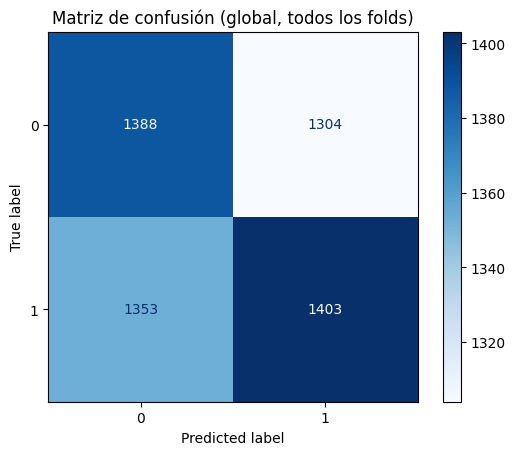

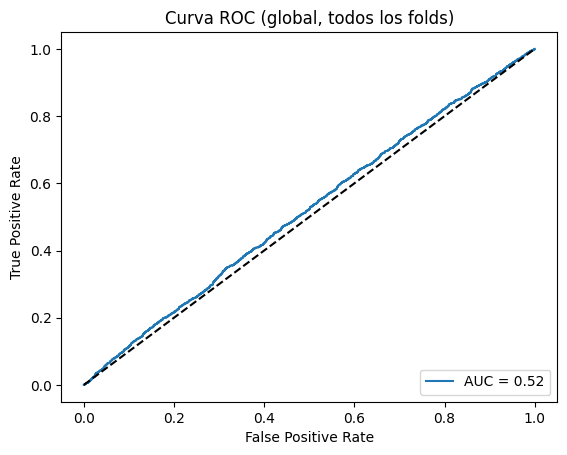


📊 Métricas por fold y modelo:
    accuracy  precision    recall        f1       mcc  fold     model  \
0   0.511013   0.553435  0.580000  0.566406  0.006515     1      LSTM   
1   0.511013   0.553435  0.580000  0.566406  0.006515     1      LSTM   
2   0.511013   0.553435  0.580000  0.566406  0.006515     1      LSTM   
3   0.511013   0.553435  0.580000  0.566406  0.006515     1      LSTM   
4   0.519824   0.576923  0.480000  0.524017  0.048548     1       GRU   
5   0.519824   0.576923  0.480000  0.524017  0.048548     1       GRU   
6   0.519824   0.576923  0.480000  0.524017  0.048548     1       GRU   
7   0.519824   0.576923  0.480000  0.524017  0.048548     1       GRU   
8   0.515419   0.575000  0.460000  0.511111  0.043419     1  LSTM+CNN   
9   0.515419   0.575000  0.460000  0.511111  0.043419     1  LSTM+CNN   
10  0.515419   0.575000  0.460000  0.511111  0.043419     1  LSTM+CNN   
11  0.515419   0.575000  0.460000  0.511111  0.043419     1  LSTM+CNN   
12  0.515419   0.576

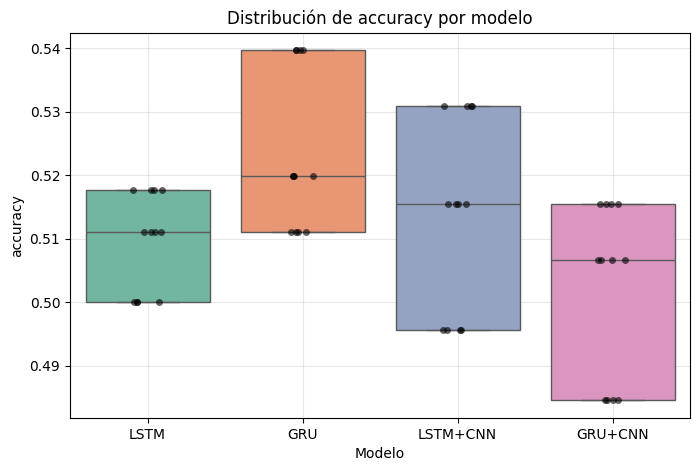

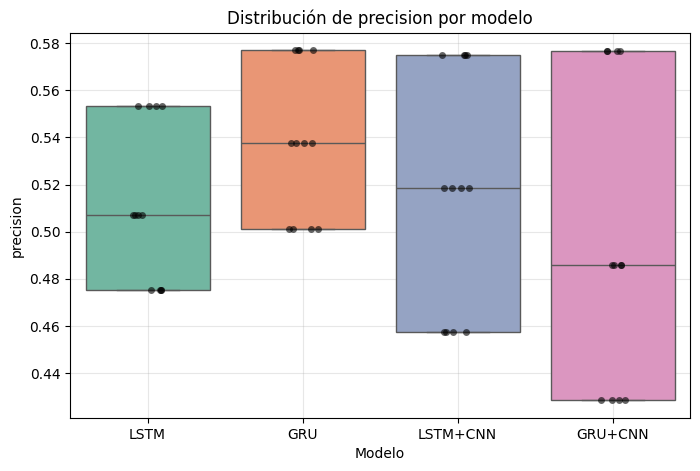

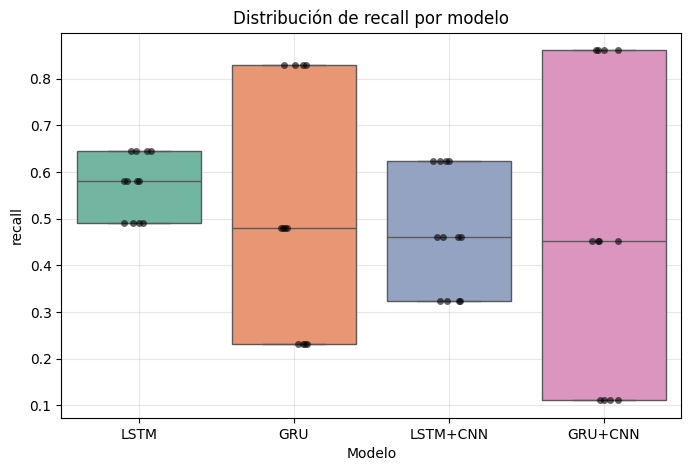

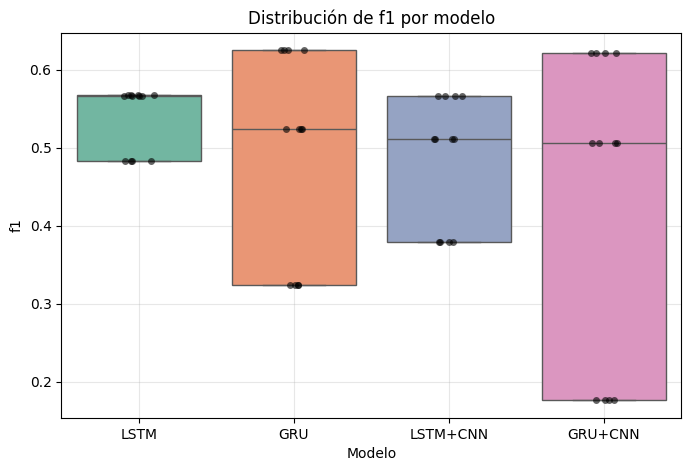

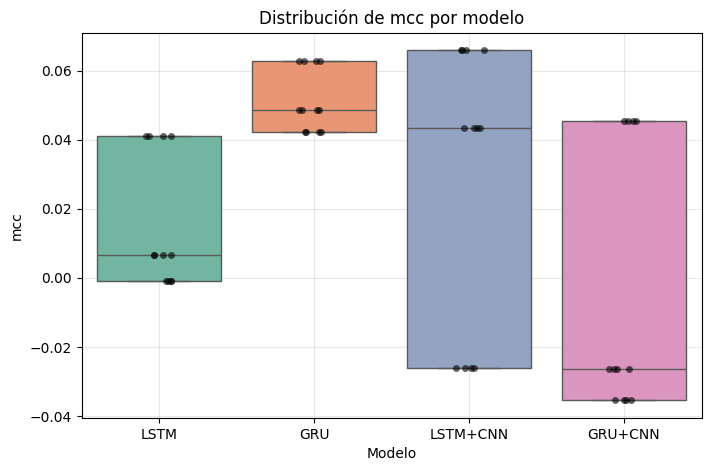

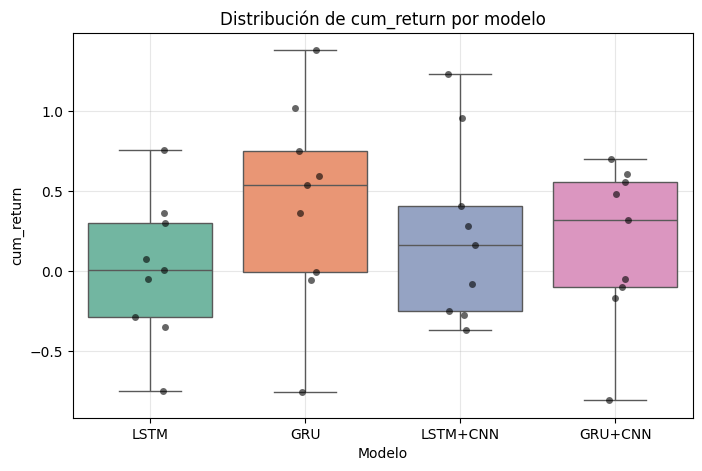

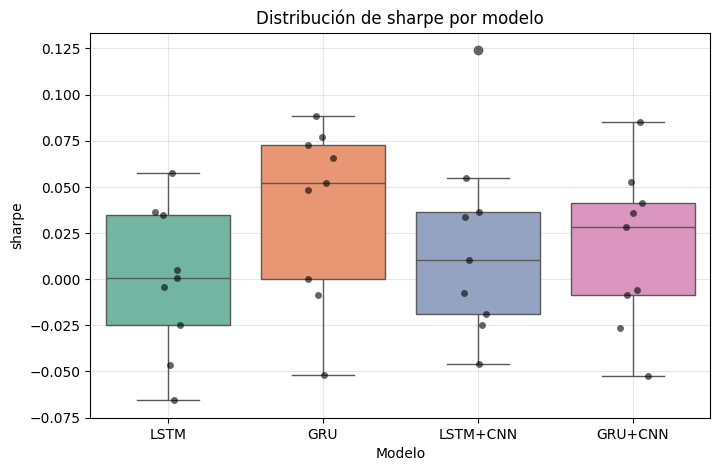

In [138]:
# === Prepara los datos ===
df_bitcoin["Open time"] = pd.to_datetime(df_bitcoin["Open time"])
df_bitcoin = df_bitcoin.set_index("Open time")

df_bitcoin["Return"] = np.log(df_bitcoin["Close"] / df_bitcoin["Close"].shift(1)).fillna(0)

# === Ejecutar pipeline ===
results, summary = run_pipeline_walkforward(
    df_bitcoin,
    target_col="Target",
    return_col="Return",
    window_size=30,
    horizon=1,
    scaler_type="robust",
    n_splits=5,
    n_test_splits=1,
    min_train_splits=2
)

# === Ver resultados ===
print("\n📊 Métricas por fold y modelo:")
print(results)

print("\n📈 Resumen (promedio ± std):")
print(summary)

# === Visualización de resultados ===
plot_boxplots(results)

In [139]:
# =======================================
# IMPORTS
# =======================================
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns
#
#from sklearn.preprocessing import RobustScaler, StandardScaler
#from sklearn.metrics import (accuracy_score, precision_score, recall_score,
#                             f1_score, matthews_corrcoef)
#
#from sklearn.model_selection import BaseCrossValidator
#from sklearn.ensemble import RandomForestClassifier
#from boruta import BorutaPy
#
#import tensorflow as tf
#from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.layers import (Dense, Dropout, LSTM, GRU, Conv1D, MaxPooling1D,
#                                     Flatten, Input, LayerNormalization)
#from tensorflow.keras.layers import MultiHeadAttention
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#
## =======================================
## SPLIT PURGADO WALK-FORWARD
## =======================================
#class PurgedTimeSeriesSplit(BaseCrossValidator):
#    def __init__(self, n_splits=4, embargo=0, test_size=0.2):
#        self.n_splits = n_splits
#        self.embargo = embargo
#        self.test_size = test_size
#
#    def split(self, X, y=None, groups=None):
#        n_samples = len(X)
#        test_size = int(n_samples * self.test_size)
#        n_trainval = n_samples - test_size
#        fold_sizes = np.linspace(0.5, 1.0, self.n_splits+1)
#
#        for i in range(self.n_splits):
#            end = int(fold_sizes[i+1] * n_trainval)
#            val_size = int(0.15 * end)
#            val_start = end - val_size
#            val_end = end
#            train_end = max(0, val_start - self.embargo)
#            train_idx = np.arange(0, train_end)
#            val_idx = np.arange(val_start, val_end)
#
#            yield train_idx, val_idx
#
#    def get_n_splits(self, X=None, y=None, groups=None):
#        return self.n_splits
#
## =======================================
## MÉTRICA F1 PERSONALIZADA
## =======================================
#def f1_score_metric(y_true, y_pred):
#    y_true = tf.cast(y_true, tf.float32)
#    y_pred = tf.round(tf.cast(y_pred, tf.float32))
#    tp = tf.reduce_sum(y_true * y_pred)
#    fp = tf.reduce_sum((1 - y_true) * y_pred)
#    fn = tf.reduce_sum(y_true * (1 - y_pred))
#    precision = tp / (tp + fp + tf.keras.backend.epsilon())
#    recall = tp / (tp + fn + tf.keras.backend.epsilon())
#    return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
#
## =======================================
## CREACIÓN DE SECUENCIAS
## =======================================
#def create_windows_multivariate_np(data, target, window_size, horizon=1, shuffle=False):
#    if isinstance(data, pd.DataFrame):
#        data = data.values
#    if isinstance(target, (pd.DataFrame, pd.Series)):
#        target = target.values
#
#    X, y = [], []
#    for i in range(len(data) - window_size - horizon + 1):
#        X.append(data[i:i+window_size, :])
#        y.append(target[i+window_size+horizon-1])
#
#    X, y = np.array(X), np.array(y)
#
#    if shuffle:
#        idx = np.arange(X.shape[0])
#        np.random.shuffle(idx)
#        X, y = X[idx], y[idx]
#
#    return X, y
#
## =======================================
## MODELOS BASE
## =======================================
#def build_lstm_simple(input_shape):
#    model = Sequential([
#        LSTM(64, input_shape=input_shape, return_sequences=False),
#        Dropout(0.2),
#        Dense(32, activation="relu"),
#        Dropout(0.2),
#        Dense(1, activation="sigmoid")
#    ])
#    model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=[f1_score_metric])
#    return model
#
#def build_gru_simple(input_shape):
#    model = Sequential([
#        GRU(64, input_shape=input_shape, return_sequences=False),
#        Dropout(0.2),
#        Dense(32, activation="relu"),
#        Dropout(0.2),
#        Dense(1, activation="sigmoid")
#    ])
#    model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=[f1_score_metric])
#    return model
#
#def build_lstm_cnn_simple(input_shape):
#    model = Sequential([
#        Conv1D(32, kernel_size=3, activation="relu", input_shape=input_shape),
#        MaxPooling1D(pool_size=2),
#        LSTM(32, return_sequences=False),
#        Dropout(0.2),
#        Dense(16, activation="relu"),
#        Dense(1, activation="sigmoid")
#    ])
#    model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=[f1_score_metric])
#    return model
#
#def build_gru_cnn_simple(input_shape):
#    model = Sequential([
#        Conv1D(32, kernel_size=3, activation="relu", input_shape=input_shape),
#        MaxPooling1D(pool_size=2),
#        GRU(32, return_sequences=False),
#        Dropout(0.2),
#        Dense(16, activation="relu"),
#        Dense(1, activation="sigmoid")
#    ])
#    model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=[f1_score_metric])
#    return model
#
## =======================================
## NUEVOS MODELOS (TRANSFORMER + TCN)
## =======================================
#def build_transformer_encoder(input_shape, num_heads=4, ff_dim=64):
#    inputs = Input(shape=input_shape)
#    x = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
#    x = LayerNormalization(epsilon=1e-6)(x)
#    x = Dense(ff_dim, activation="relu")(x)
#    x = Flatten()(x)
#    x = Dropout(0.3)(x)
#    outputs = Dense(1, activation="sigmoid")(x)
#    model = Model(inputs, outputs)
#    model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=[f1_score_metric])
#    return model
#
#def build_tcn_simple(input_shape, nb_filters=32, kernel_size=3, nb_stacks=1, dilations=[1,2,4,8]):
#    from tcn import TCN
#    model = Sequential([
#        TCN(nb_filters=nb_filters, kernel_size=kernel_size, dilations=dilations,
#            nb_stacks=nb_stacks, dropout_rate=0.2, return_sequences=False,
#            input_shape=input_shape),
#        Dense(32, activation="relu"),
#        Dropout(0.2),
#        Dense(1, activation="sigmoid")
#    ])
#    model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=[f1_score_metric])
#    return model
#
## =======================================
## EVALUACIÓN
## =======================================
#def evaluate_metrics(y_true, y_pred, returns=None):
#    metrics = {
#        "accuracy": accuracy_score(y_true, y_pred),
#        "precision": precision_score(y_true, y_pred, zero_division=0),
#        "recall": recall_score(y_true, y_pred, zero_division=0),
#        "f1": f1_score(y_true, y_pred, zero_division=0),
#        "mcc": matthews_corrcoef(y_true, y_pred)
#    }
#    if returns is not None:
#        strat_returns = np.where(y_pred==1, returns, -returns)
#        metrics["cum_return"] = strat_returns.cumsum()[-1]
#        metrics["sharpe"] = strat_returns.mean() / (strat_returns.std() + 1e-8)
#    return metrics
#
## =======================================
## FEATURE IMPORTANCE
## =======================================
#def permutation_importance_seq(model, X_val, y_val, features, n_repeats=5):
#    baseline_acc = accuracy_score(y_val, (model.predict(X_val) > 0.5).astype(int))
#    importances = {}
#    for j, feat in enumerate(features):
#        scores = []
#        X_val_permuted = X_val.copy()
#        for _ in range(n_repeats):
#            np.random.shuffle(X_val_permuted[:, :, j])
#            acc = accuracy_score(y_val, (model.predict(X_val_permuted) > 0.5).astype(int))
#            scores.append(baseline_acc - acc)
#        importances[feat] = np.mean(scores)
#    return pd.Series(importances).sort_values(ascending=False)
#
## =======================================
## RESUMEN DE MÉTRICAS
## =======================================
#def summarize_results(metrics_df):
#    summary = metrics_df.groupby("model").agg(["mean", "std"])
#    # ordenar por F1
#    summary = summary.sort_values(("f1", "mean"), ascending=False)
#    return summary.round(4)
#
#def aggregate_feature_importances(feature_importances_all, top_n=10):
#    agg_results = {}
#    for model_name in set([d["model"] for d in feature_importances_all]):
#        imps = [d["importances"] for d in feature_importances_all if d["model"] == model_name]
#        if imps:
#            imp_mean = pd.concat(imps, axis=1).mean(axis=1).sort_values(ascending=False)
#            agg_results[model_name] = imp_mean.head(top_n)
#            plt.figure(figsize=(8,5))
#            imp_mean.head(top_n).plot(kind="barh")
#            plt.gca().invert_yaxis()
#            plt.title(f"Top-{top_n} Features ({model_name})")
#            plt.show()
#    return agg_results
#
#def plot_feature_importance_heatmap(feature_importances_all, top_n=10):
#    agg_results = aggregate_feature_importances(feature_importances_all, top_n)
#    df_heatmap = pd.DataFrame(agg_results).fillna(0)
#    plt.figure(figsize=(10,6))
#    sns.heatmap(df_heatmap, annot=True, fmt=".3f", cmap="YlOrBr")
#    plt.title(f"Heatmap Features vs Modelos (Top-{top_n})")
#    plt.show()
#
## =======================================
## PIPELINE WALK-FORWARD
## =======================================
#def run_pipeline_walkforward(df, target_col="Target", return_col="Return",
#                             window_size=30, horizon=1, n_splits=6, scaler_type="robust"):
#    embargo = window_size + horizon - 1
#    test_size = int(len(df) * 0.2)
#
#    df_trainval = df.iloc[:-test_size]
#    features = [c for c in df.columns if c not in [target_col, return_col]]
#    print(f"\n📌 Usando todas las features: {features}")
#
#    X_all = df_trainval[features].values
#    y_all = df_trainval[target_col].values
#    returns_all = df_trainval[return_col].values
#    X_all_seq, y_all_seq = create_windows_multivariate_np(X_all, y_all, window_size, horizon)
#    ret_seq = returns_all[window_size+horizon-1:]
#
#    splitter = PurgedTimeSeriesSplit(n_splits=n_splits, embargo=embargo, test_size=0.2)
#    metrics_list, feature_importances_all = [], []
#
#    models = {
#        "LSTM": build_lstm_simple,
#        "GRU": build_gru_simple,
#        "LSTM+CNN": build_lstm_cnn_simple,
#        "GRU+CNN": build_gru_cnn_simple,
#        "Transformer": build_transformer_encoder,
#        "TCN": build_tcn_simple
#    }
#
#    for fold, (train_idx, val_idx) in enumerate(splitter.split(X_all_seq)):
#        print(f"\n=== Fold {fold+1}/{n_splits} ===")
#        X_train_raw, y_train = X_all_seq[train_idx], y_all_seq[train_idx]
#        X_val_raw, y_val = X_all_seq[val_idx], y_all_seq[val_idx]
#        r_val = ret_seq[val_idx]
#
#        scaler = RobustScaler() if scaler_type=="robust" else StandardScaler()
#        n_samples, seq_len, n_features = X_train_raw.shape
#        X_train_scaled = scaler.fit_transform(X_train_raw.reshape(-1, n_features)).reshape(n_samples, seq_len, n_features)
#        X_val_scaled = scaler.transform(X_val_raw.reshape(-1, n_features)).reshape(X_val_raw.shape[0], seq_len, n_features)
#
#        for name, fn in models.items():
#            print(f"\n--- Modelo: {name} ---")
#            model = fn(X_train_scaled.shape[1:])
#            es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
#            rlrop = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-5)
#            ckpt = ModelCheckpoint(f"best_{name}_fold{fold+1}.keras", save_best_only=True)
#
#            model.fit(X_train_scaled, y_train,
#                      validation_data=(X_val_scaled, y_val),
#                      epochs=50, batch_size=32,
#                      callbacks=[es, rlrop, ckpt], verbose=0)
#
#            y_pred_val = (model.predict(X_val_scaled) > 0.5).astype("int32")
#            metrics_val = evaluate_metrics(y_val, y_pred_val, returns=r_val)
#            metrics_val.update({"fold": fold+1, "model": name})
#            metrics_list.append(metrics_val)
#
#            imp = permutation_importance_seq(model, X_val_scaled.copy(), y_val, features)
#            feature_importances_all.append({"fold": fold+1, "model": name, "importances": imp})
#
#    return pd.DataFrame(metrics_list), feature_importances_all
#